#Goal

The VP of Product is interested in having a holistic view of conversion rate, especially focusing on actionable insights. What are your main findings looking at the data and what would be your top 3 product ideas to increase conversion rate?

## Data summary: 
Each row in the data set is a visit to the site from a given user.

user_id : the ID of the user

source : marketing channel that led to the user coming to the site. It can be:
ads [“google”, “facebook”, “bing”, “yahoo”, “other”]. That is, user coming from google ads, yahoo ads, etc.
seo - [“google”, “facebook”, “bing”, “yahoo”, “other”]. That is, user coming from google google search, yahoo, facebook, etc.
friend_referral : user coming from a referral link of another user
direct_traffic: user coming by directly typing the address of the site on the browser

device : user device. Can be mobile or web

operative_system : user operative system. Can be: “windows”, “linux”, “mac” for web, and “android”, “iOS” for mobile. Other if it is none of the above

lat: user location (latitude), based on user ip address

long : user location (longitude), based on user ip address

weekday: on which day of the week this user visited my site. Useful to understand weekly patterns

yearweek: in which week of the year this user visited my site. Useful to understand seasonality (only includes from week 10 to 22, meaning from March to end of May)

converted : Our label, i.e. whether the user converted (i.e. 1 -> bought the product within that session) or not (0 -> left the site without buying). The project goal is to figure out how to increase the number of users who convert

# Analysis

In [ ]:
!pip install pandas-profiling==2.8.0 --quiet
!jupyter nbextension enable --py widgetsnbextension
#install Rulefit from github 
!pip install git+https://github.com/christophM/rulefit.git --quiet

In [ ]:
import sys
from pandas_profiling import ProfileReport
from math import e
import statsmodels.api as sm 
import numpy as np

import pandas
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

import graphviz
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from rulefit import RuleFit



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#read from google drive
df = pandas.read_csv('https://drive.google.com/uc?export=download&id=1H_-mi6NzeZt1PhcanHofcf3H6UiItmxO')
profile = ProfileReport(df, title="Pandas Profiling Report",  explorative=True)

In [ ]:
df.head()

,user_id,source,device,operative_system,lat,long,weekday,yearweek,converted
0,3,seo_facebook,web,mac,38.89,-94.81,Friday,16,0
1,9,seo-google,mobile,android,41.68,-72.94,Friday,18,0
2,14,friend_referral,mobile,iOS,39.74,-75.53,Saturday,13,0
3,16,ads-google,mobile,android,37.99,-121.80,Friday,21,0
4,19,ads-google,mobile,android,41.08,-81.52,Wednesday,14,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           275616 non-null  int64  
 1   source            275616 non-null  object 
 2   device            275616 non-null  object 
 3   operative_system  275616 non-null  object 
 4   lat               275616 non-null  float64
 5   long              275616 non-null  float64
 6   weekday           275616 non-null  object 
 7   yearweek          275616 non-null  int64  
 8   converted         275616 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 18.9+ MB


In [ ]:
profile.to_widgets()

# Analysis plan

To analyze these data we will take the following steps:
*    Run logistic regression against the target label
*    Run decision tree against the target label 
*    Run Rulefit against the target label
*    Combine obersational insights across all models to generate main findings and top 3 product ideas to increase conversion rate






In [ ]:
data_categorical = df.select_dtypes(['object']).astype("category") 
print(data_categorical.apply(lambda x: x.cat.categories[0]))

source              ads-bing
device                mobile
operative_system     android
weekday               Friday
dtype: object


# Logistic Regression


In [ ]:
#Make dummy variables from the df categorical 
data = pandas.get_dummies(df, drop_first=True)
  
#add intercept
data['intercept'] = 1
#drop the label from df
train_cols = data.drop('converted', axis=1)
  
#Build Logistic Regression
logit = sm.Logit(data['converted'], train_cols)
output = logit.fit()

         Current function value: 0.089555
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#build output table dataframe from output
output_table = pandas.DataFrame(dict(coefficients = output.params, SE = output.bse, z = output.tvalues, p_values = output.pvalues))
#get coefficients and pvalues
print(output_table)

                          coefficients            SE          z       p_values
user_id                   2.620194e-08  4.946964e-08   0.529657   5.963498e-01
lat                      -5.316089e-03  2.768778e-03  -1.920013   5.485627e-02
long                     -1.061962e-04  8.012621e-04  -0.132536   8.945602e-01
yearweek                 -7.336524e-04  3.814630e-03  -0.192326   8.474869e-01
source_ads-google         5.870313e-01  7.199678e-02   8.153577   3.533160e-16
source_ads-yahoo          2.004106e-01  1.217949e-01   1.645476   9.987167e-02
source_ads_facebook       5.773647e-01  7.277078e-02   7.934018   2.121665e-15
source_ads_other          1.865445e-01  8.344581e-02   2.235517   2.538346e-02
source_direct_traffic     1.547397e-02  7.642260e-02   0.202479   8.395423e-01
source_friend_referral    1.177281e+00  7.602926e-02  15.484575   4.409649e-54
source_seo-bing           5.738001e-01  1.726991e-01   3.322543   8.920106e-04
source_seo-google         3.567429e-01  8.499189e-02

In [ ]:
#only keep significant variables and sort by coefficient
output_significant = output_table.loc[output_table['p_values'] < 0.05].sort_values("coefficients", ascending=False)

In [ ]:
print(output_significant)

                        coefficients        SE          z       p_values
source_friend_referral      1.177281  0.076029  15.484575   4.409649e-54
source_ads-google           0.587031  0.071997   8.153577   3.533160e-16
source_ads_facebook         0.577365  0.072771   7.934018   2.121665e-15
source_seo-bing             0.573800  0.172699   3.322543   8.920106e-04
operative_system_iOS        0.407536  0.040065  10.171930   2.646118e-24
source_seo-google           0.356743  0.084992   4.197376   2.700258e-05
source_seo-yahoo            0.336044  0.120564   2.787261   5.315571e-03
source_seo_facebook         0.290116  0.087898   3.300615   9.647307e-04
source_seo-other            0.287583  0.110455   2.603607   9.224834e-03
source_ads_other            0.186544  0.083446   2.235517   2.538346e-02
weekday_Tuesday            -0.142619  0.066179  -2.155058   3.115732e-02
operative_system_other     -0.170095  0.082942  -2.050765   4.028980e-02
intercept                  -4.409939  0.168811 -26.

In [ ]:
e**output_significant.iloc[0:1,0]

source_friend_referral    3.245537
Name: coefficients, dtype: float64

In [ ]:
e**output_significant.iloc[1:2,0]

source_ads-google    1.798641
Name: coefficients, dtype: float64

## General Insights


*   Friend referral as a source seems very important in influencing whether a user converts in this dataset. The source_friend_referral has 3.24 times the odds of the reference source variable (ads-bing) of converting. This source of traffic has over double the odds of converting vs. the next highest coefficient with significance (source_ads-google). 

  * Recommendation: It may be worth exploring how this source label is recorded in the onboarding process to see whether this is just a correlation or is actually a causal relationship. If we can determine that it's a causal relationship (potentially with a test), then we should prioritize campaigns where we incentivize current users to get their friends to join with an incentive. We should look at sementing our current users to see how the performance of the referral link process also varies by each user-segment.

* Both source_ads-google and source_ads_facebook have higher odds of converting than SEO sources. This is interesting because Google and Bing both recommend 'owning' the top search result, but SEO is historically a higher quality source of traffic. 
  * Recommendation: If we're currently over-bidding to own the top ad slot in SERPs there's a chance we may just be diverting quality SEO traffic to our site through this top slot. We should split test on Google ads randomly abstaining from showing a few branded keywords and re-running this model to compare before/after the period. If we see that the coefficients for these sources flip during the time-period of the test, that result may suggest that we've simply been diverting quality traffic to our ad clicks (lowering our margin) that would've clicked on organic results (free) anyway.

* operative_system_iOS seems important in influencing whether a user converts in this data set. This may indicate that we have a better page-loading experience on iOS vs. other devices, and we should investigate whether users on other devices are having trouble getting through the flow, or whether the page loads materially faster on one device vs. another. If we find any of these behaviors, we should implement fixes and monitor for improvement across product key metrics, grouping by operating system. 



# Decision Tree

In [ ]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
  

data = pandas.get_dummies(df, drop_first=True)
train_cols = data.drop('converted', axis=1)

#build the tree
tree=DecisionTreeClassifier(
    #set max tree dept at 4. 
    max_depth=6,
    #change weights given that we have unbalanced classes. Our data set is now perfectly balanced. It makes easier to look at tree output
    class_weight="balanced",
    #only split if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which might lead to irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data['converted'])
  
#visualize it
export_graphviz(tree, out_file="tree_.dot", feature_names=train_cols.columns, proportion=True)


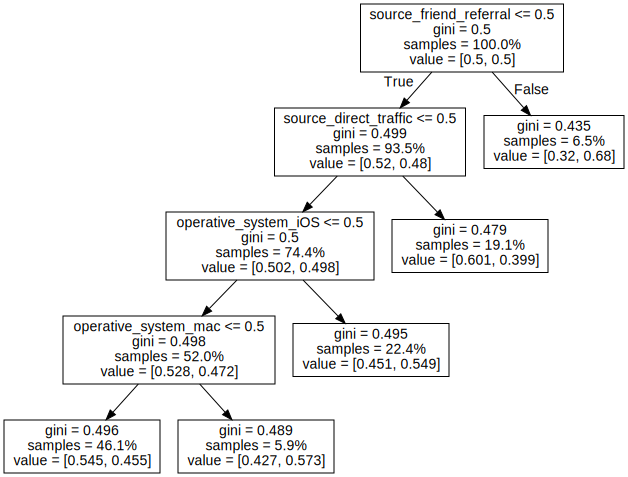

In [ ]:
Source.from_file("/content/tree_.dot")

## General Insights


*   None of the gini indexes here are very good, considering that most are still above .45. The only one that dips below .45 gini index is the first leaf (which is 'source_friend_referral <= 0.5 is FALSE', indicating these are people that converted and had a source_friend_referral ). The proportion of events in this node is 6.5% so it doesn't capture a lot of the total events in the dataset. The class 0/1 values are respectively, 32% and 68% so this leaf has identified a segment with a higher percentage of people who convert.

*   If we continue down the tree, we don't see a structure that's particularly useful for generating insights over the logistic regression. There aren't any combinations of feature_1 and feature_2 that are meaningful. 

# Rulefit

In [ ]:

rf=RandomForestClassifier(max_depth=2, n_estimators=10, class_weight={0:0.05,1:0.95})
  
#set RuleFit parameters. 
""" We are keeping RuleFit pretty small here to make it faster. 
Increasing max_depth, n_estimators, and setting exp_rand_tree_size = True 
will generate way more rules and make it somewhat more reliable. 
As always, there is a trade-off between accuracy and processing time, 
which should be considered on a case-by-case basis. 
Note that RuleFit is really slow, so this trade-off is pretty significant here. """

rufi=RuleFit(rfmode="classify", tree_generator=rf, exp_rand_tree_size=False, lin_standardise=False)
#fit RuleFit
rufi.fit(train_cols.values, data['converted'].values, feature_names = train_cols.columns)
print("We have extracted", rufi.transform(train_cols.values).shape[1], "rules")


We have extracted 37 rules


In [ ]:
#These are a few of the rules we have extracted
output=rufi.get_rules()
print(output[output['type']=="rule"]['rule'].head().values)

['operative_system_linux <= 0.5 & source_friend_referral <= 0.5'
 'source_seo-google <= 0.5 & source_direct_traffic <= 0.5'
 'weekday_Tuesday <= 0.5 & source_ads_other > 0.5'
 'source_friend_referral > 0.5 & source_ads_other <= 0.5'
 'lat > 27.885000228881836 & source_direct_traffic > 0.5']


In [ ]:
pandas.set_option('display.width', 500)

#X_concat is the new dataset given by the original variables (train_cols.values)
#as well as the new rules extracted from the trees (rufi.transform(train_cols.values))
X_concat = np.concatenate((train_cols, rufi.transform(train_cols.values)), axis=1)
#Build the logistic regression with penalty. This will set low coefficients to zero, so only the relevant ones will survive
log = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
log.fit(X_concat, data['converted'])
#get the full output with variables, coefficients, and support
output.iloc[:,2] = np.transpose(log.coef_)
output[output['coef']!=0].sort_values('coef', ascending = False )

,rule,type,coef,support,importance
16,operative_system_iOS,linear,3.980483e-01,1.000000,0.000000
4,source_ads-google,linear,3.473104e-01,1.000000,0.000000
6,source_ads_facebook,linear,3.372113e-01,1.000000,0.000000
41,operative_system_mac > 0.5 & long <= -122.1450...,rule,2.485292e-01,0.003906,0.000000
63,source_friend_referral > 0.5 & weekday_Monday ...,rule,1.327725e-01,0.061983,0.000000
10,source_seo-bing,linear,5.343699e-02,1.000000,0.000000
14,source_seo_facebook,linear,2.402018e-02,1.000000,0.000000
23,weekday_Sunday,linear,5.365258e-03,1.000000,0.000000
33,source_friend_referral > 0.5 & yearweek <= 10.5,rule,1.480074e-03,0.005118,0.000000
2,long,linear,9.496340e-04,1.000000,0.327020


## General Insights


*  operative_system_mac > 0.5 & long <= -122.14500045776367 is an interesting rule because of it's relationship to a geographic area. Because of the small volume of support (almost false for everyone) it makes me wonder if test traffic from california isn't being properly filtered out of the production dataset

* user_id > 37702.5 & source_direct_traffic > 0.5  and  source_direct_traffic > 0.5 & user_id <= 995526.5 are interesting rules to me (somewhat large negative coefficients and between 0.18-0.19 support). If the user_id naming convention was sequential in this system, then this may indicate the quality of direct traffic suffered between users 37.7k - 995k. Perhaps these users saw a different onboarding flow experience.



# Recommendations

**Bottom line:** the source of friend_referral seems to be performing extremely well, and we should prioritize understanding the causal relationships that exist in this traffic source before moving onto optimizing sources further down the decision tree.

1.  We should design a randomized test that validates whether source_friend_referral is a causal relationship to increasing conversions. 

2.  We should look at sementing our current users to see how the conversion performance of the referral link process varies by each user-segment. Perhaps there are some segments that are more impactful than others, and we can tailor our approach to increase volume through personalizing our messages to each segment.

3.   We should prioritize ideation of campaigns where we incentivize current users to get their friends to join with an incentive before we look at simply increasing advertising volume spend. Ideally, until this source starts to level off in terms of incremental cost per conversion compared to other channels.
 


